# TP: Essaims de nano-satellites -- *Nanosatellite swarms*

Ce TP a pour objectif de vous familiariser davantage avec les topologies d'essaims de nano-satellites en exploitant un jeu de données. Vous verrez notamment qu'on peut extraire énormément d'informations à partir d'un jeu de données simple (ici, positions des satellites par pas de temps). Le TP se déroule en 3 parties :  

1. Chargement des données : découverte du jeu de données et formattage pour la suite
2. Visualisation de la topologie
3. Partage de charge : division en sous-réseaux

Nous allons d'abord importer les librairies nécessaires, dont le module de simulation `swarm_sim` disponible dans le dossier `\tp`.  

***

*The objective of this TP is to become familiar with nanosatellite swarms topologies extracted from a given dataset. You'll notice in particular that one can extract a lot of information from a rather simple dataset (here, temporal satellite positions). This TP is divided in 3 parts:*  

1.  *Data loading: dataset exploration and initialization*
2.  *Visualization of the topologies*
3.  *Data load balancing: division into sub-networks*  

*We will first import and the necessary Python libraries, namely the simulation module* `swarm_sim` *that you can find under the* `\tp` *directory.*  

*Make sure you choose the* `.venv` *environment for execution.*

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

from swarm_sim import *

In [2]:
import sys
print(sys.executable)

c:\Users\yyounes\swarmyy\Scripts\python.exe


## 1. Chargement des données -- *Data loading*

Les données sont stockées dans le dossier `\data\swarm-50-sats-scenario` du repository Git, et sont réparties en 50 traces de nano-satellites échantillonnées sur 24 heures.  

Ouvrez une trace en exécutant la cellule suivante, et rappelez les champs ainsi que les unités utilisées (n'hésitez pas à revoir le cours, slide 20).

***

*The dataset is available under the* `\data\swarm-50-sats-scenario` *folder of the Git repository. It consists of 50 separate nanosatellite tracks sampled over 24 hours.*  

*Open one track by executing the following cell, and pay attention to the fields and units (slide 35).*

In [3]:
PATH = '..\\data\\swarm-50-sats-scenario\\coords_v1_if_LLO-' #You might need to adapt, depending on the OS
NB_NODES = 50
DURATION = 8641 # Number of data samples, not time!
REVOLUTION = 1800 # Number of data rows to complete a revolution around the Moon
CONNECTION_RANGE = 30 # km

row_metadata_end = 6
row_data_start = 7

sat_id = 0
df_metadata = pd.read_csv(PATH+str(sat_id)+'.csv', skiprows = lambda x: x>row_metadata_end)
df_data = pd.read_csv(PATH+str(sat_id)+'.csv', skiprows= lambda x: x<row_data_start, header=0)
        
print(df_metadata)
df_data.head()

     sat1Name        LLO-0
0    sat1Smaj  3416.853000
1     sat1Ecc     0.361882
2     sat1Inc    91.048550
3    sat1RAAN   238.822672
4  sat1ArgPer   292.400969
5  sat1TrAnom     0.000000


Time[EpSec]       xF[km]       yF[km]       zF[km]      xI[km]      yI[km]  \
0          0.0   997.833970 -1128.770350 -1576.120871 -398.587611 -729.991953   
1         10.0  1002.088984 -1141.149732 -1564.489841 -407.058250 -743.753719   
2         20.0  1006.295944 -1153.475366 -1552.784813 -415.509636 -757.480307   
3         30.0  1010.454657 -1165.746669 -1541.006346 -423.941371 -771.171070   
4         40.0  1014.564936 -1177.963066 -1529.155006 -432.353058 -784.825365   

        zI[km]  
0 -2015.487980  
1 -2008.772633  
2 -2001.962275  
3 -1995.057233  
4 -1988.057848

Chargez la totalité des données dans ce notebook. Nous allons créer un dictionnaire contenant ces données suivant ce format : 

`satellites[id] = track`

Modifiez la variable `PATH` si nécessaire.

NB : le chargement peut être assez long (plusieurs minutes en fonction de la machine). Vous pouvez visualiser la progression du chargement avec la fonction `tqdm()`.  

***

*You can now load the whole dataset into a Python dictionary formatted as follows:*  

`satellites[id] = track`  

*Modify the* `PATH` *variable if necessary.*  

*NB: the loading can take some time (sometimes a couple minutes, depending on the machine). You can visualize the progression of the loading with the* `tqdm()` *function.*

In [4]:
metadata = {}
satellites = {}

with tqdm(total=NB_NODES, desc='Extracting data') as pbar:
    for i in range(NB_NODES):
        df_metadata = pd.read_csv(PATH+str(i)+'.csv', skiprows = lambda x: x>row_metadata_end)
        metadata[i] = df_metadata
        df_data = pd.read_csv(PATH+str(i)+'.csv', skiprows= lambda x: x<row_data_start, header=0)
        satellites[i] = df_data
        pbar.update(1)
        
satellites[0].head()

Extracting data:   0%|          | 0/50 [00:00<?, ?it/s]

Extracting data: 100%|██████████| 50/50 [00:01<00:00, 27.11it/s]


Time[EpSec]       xF[km]       yF[km]       zF[km]      xI[km]      yI[km]  \
0          0.0   997.833970 -1128.770350 -1576.120871 -398.587611 -729.991953   
1         10.0  1002.088984 -1141.149732 -1564.489841 -407.058250 -743.753719   
2         20.0  1006.295944 -1153.475366 -1552.784813 -415.509636 -757.480307   
3         30.0  1010.454657 -1165.746669 -1541.006346 -423.941371 -771.171070   
4         40.0  1014.564936 -1177.963066 -1529.155006 -432.353058 -784.825365   

        zI[km]  
0 -2015.487980  
1 -2008.772633  
2 -2001.962275  
3 -1995.057233  
4 -1988.057848

Afin de faciliter la suite du traitement, nous allons créer un objet `Swarm` tel que défini dans le module `swarm_sim` par pas de temps et les stocker dans un dictionnaire tel que :

`swarm_data[timestamp] = Swarm`

N'hésitez pas à lire la doc pour le formattage en objet `Swarm`.  

***

*In order to simplify the following data analysis, we will create* `Swarm` *objects as defined in the* `swarm_sim` *module for each timestamp, and stock them in a dictionary such as:*  

`swarm_data[timestamp] = Swarm`

*Don't hesitate to take a look at the documentation to understand the formatting process.*

In [5]:
help(Swarm.__init__)
help(Node.__init__)

Help on function __init__ in module swarm_sim:

__init__(self, connection_range=0, nodes=[])
    Swarm object constructor
    
    Args:
        connection_range (int, optional): the maximum distance between two nodes to establish a connection. Defaults to 0.
        nodes (list, optional): list of Node objects within the swarm. Defaults to [].

Help on function __init__ in module swarm_sim:

__init__(self, id, x=0.0, y=0.0, z=0.0)
    Node object constructor
    
    Args:
        id (int): the ID number of the satellite (mandatory)
        x (float, optional): the x-coordinate of the satellite. Defaults to 0.0.
        y (float, optional): the y-coordinate of the satellite. Defaults to 0.0.
        z (float, optional): the z-coordinate of the satellite. Defaults to 0.0.



In [6]:
swarm_data = {}

with tqdm(total=DURATION, desc='Converting to Swarm') as pbar:
    for t in range(DURATION):
        swarm_data[t] = Swarm(connection_range=CONNECTION_RANGE,
                    nodes = [Node(id, sat['xF[km]'].iloc[t], sat['yF[km]'].iloc[t], sat['zF[km]'].iloc[t]) for id,sat in satellites.items()]
                    )
        pbar.update(1)

Converting to Swarm: 100%|██████████| 8641/8641 [00:08<00:00, 977.63it/s] 


Affichez le contenu du `swarm_data` à l'instant `0`, ainsi que la description d'un noeud de votre choix. Assurez-vous de bien comprendre tous les champs affichés.  

***

*Print the content of* `swarm_data` *at timestamp* `0`*, as well as the description of a node of your choosing. Make sure you understand all the fields.*

In [7]:
swarm = swarm_data[0]

# To do
print("Swarm at timestamp 0:", swarm)

# Choose a node to describe, for example, the first node in the swarm
node_7 = swarm.nodes[7]
print("\nDescription of the chosen node:")
print("ID:", node_7.id)
print("x Position (km):", node_7.x)
print("y Position (km):", node_7.y)
print("z Position (km):", node_7.z)

Swarm at timestamp 0: Swarm of 50 node(s), connection range: 30

Description of the chosen node:
ID: 7
x Position (km): 945.634130615792
y Position (km): -1180.8468111563109
z Position (km): -1579.8160726137935


## 2. Visualisation de la topologie -- *Topology visualization*  

Le module `swarm_sim` permet notamment de créer des graphiques 3D représentant les positions des satellites à un instant donné, avec si besoin les ISL (liens inter-satellites) existants. Il s'agit des fonctions `plot_nodes()` et `plot_edges()`.  

Affichez la topologie de l'essaim à un pas de temps donné, puis à un autre.  

Qu'observez-vous au niveau de la topologie ?  

***

*The* `swarm_sim` *module allows you to create 3D graphs representing the positions of the nanosatellites at a given time, and if needed, the existing ISL (inter-satellite links). To do so, you can use the functions* `plot_nodes()` *and* `plot_edges()`.  

*Display the swarm topology at a given time (you choose), then at another further away.*  

*What do you observe on the topologies?*

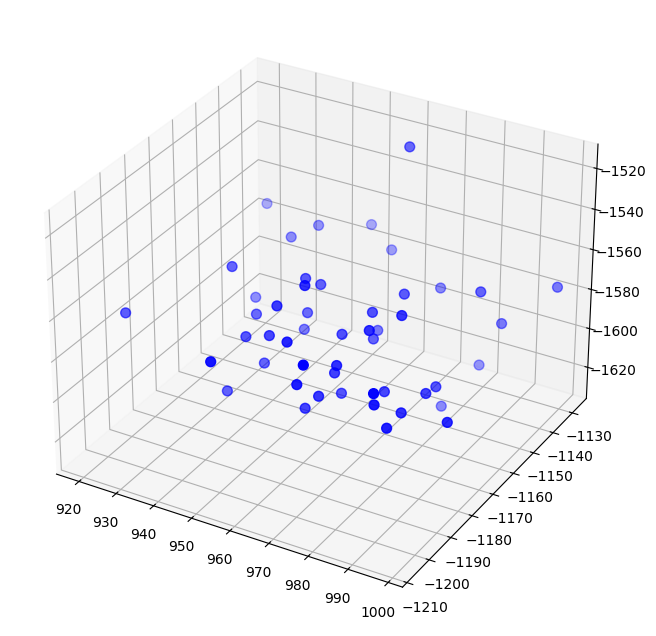

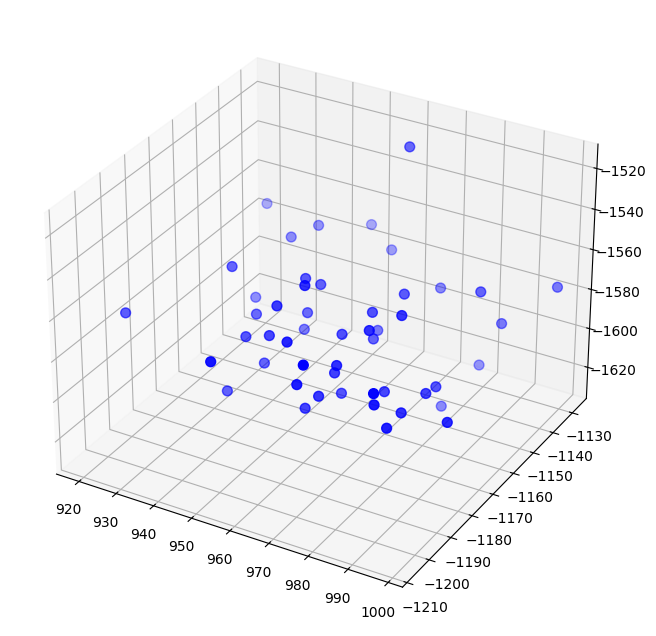

In [8]:
swarm_data[0].plot_nodes()
swarm_data[0].plot_edges()

Vous avez sûrement remarqué que la fonction `plot_edges()` ne fonctionne pas, ou du moins elle n'affiche aucune connexion dans l'essaim. Pourquoi ?  

***

*You probably noticed that* `plot_edges()` *doesn't actually return any edge. Why so?*

In [9]:
""" 
Réponse -- answer
"""

' \nRéponse -- answer\n'

*Answer* :  The `plot_edges()` function does not return any edges because it is designed solely 
for visualization, to plot the connections between nodes on a graph. It relies on the 
neighbor information being previously established by functions like `neighbor_matrix()`. 
Once the neighbor relationships are determined and stored, `plot_edges()` uses this information 
to draw the edges on the plot. There is no return value because the function's 
purpose is to produce a visual output rather than to return data.

Etablissez les connexions entre noeuds voisins grâce à la fonction `neighbor_matrix()` (regardez la doc pour comprendre comment elle fonctionne), puis affichez la topologie de l'essaim grâce à la fonction `plot_edges()`.  

***

*Establish the connections between neighbor nodes with the function* `neighbor_matrix()` *(take a look at the doc to understand how it works), then display the swarm topology with* `plot_edges()`*.*

In [10]:
help(Swarm.neighbor_matrix)

Help on function neighbor_matrix in module swarm_sim:

neighbor_matrix(self, connection_range=None)
    Function to compute the neighbor matrix of the swarm.
    If two nodes are neighbors (according to the given connection range), the row[col] equals to 1. Else 0.
    
    Args:
        connection_range (int, optional): the connection range of the swarm. Defaults to None.
    
    Returns:
        list(list(int)): the 2-dimensional neighbor matrix formatted as matrix[node1][node2] = adjacency.



In [11]:
with tqdm(total=DURATION, desc='Neighbor matrix') as pbar:
    for t in range(DURATION):
        neighbor_matrix = swarm_data[t].neighbor_matrix()
        pbar.update(1)

Neighbor matrix:   1%|          | 85/8641 [00:00<00:10, 847.65it/s]

Neighbor matrix: 100%|██████████| 8641/8641 [00:09<00:00, 909.18it/s]


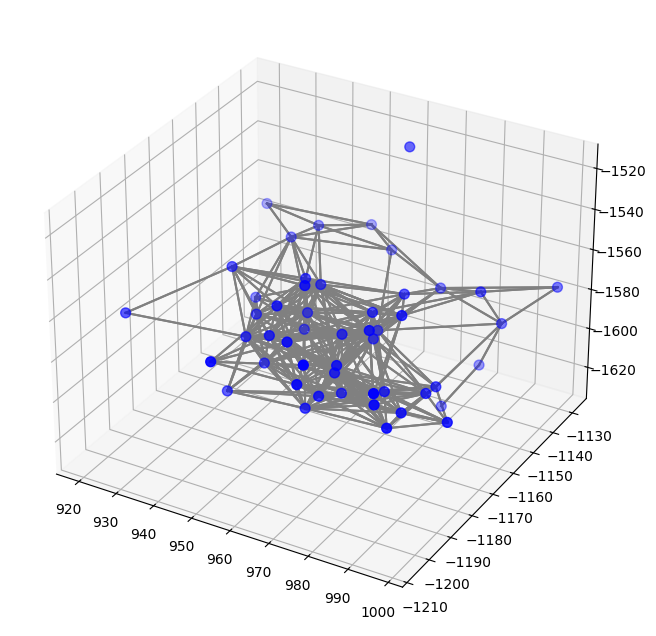

In [12]:
swarm_data[0].plot_edges()

## 3.  Partage de charge -- *Load balancing*

Nous allons maintenant nous intéresser à la gestion de la redondance et du recouvrement dans le réseau (slides 29+ du cours).

Pour rappel, lors d'une mission d'interférométrie, chaque nanosatellite va collecter près de 5 Gb de données brutes de l'espace. Afin de créer l'image globale collectée par l'essaim, toutes les données collectées doivent être échangées entre l'intégralité des satellites. Sans politique de limitation de recouvrement, le réseau va saturer très vite.

Afin de limiter ce recouvrement, une solution est de diviser le réseau en plusieurs sous-réseaux grâce à des algorithmes de **division de graphe**. En effet, les sous-réseaux obtenus vont faire office de "noeuds" dans le graphe simplifié, et on va ainsi limiter la quantité de données échangées simultanément. Nous allons analyser les performances de trois algorithmes: **Random Node Division** (`RND`), **Multiple Independent Random Walk** (`MIRW`) et **Forest Fire Division** (`FFD`).

Cherchez les fonctions correspondantes à ces algorithmes dans la doc, et assurez-vous de bien comprendre leur principe de fonctionnement. Quelles sont les différences majeures dans leur implémentation ?  

***

*We will now focus on the redundancy management and network overload control (slides 27+).*  

*Reminder: during an interferometry mission, each nanosatellite collects approx. 5 Gb of space observation raw data. IN order to create the global image collected by the swarm, all data packets need to be shared among all the satellites of the swarm. Without overload control, the network will experience strong congestion.*  

*In order to manage the data overload, one solution is to divide the network into sub-networks by using* **Graph Division** *algorithms. The resulting sub-networks can indeed act as big aggregated nodes in a simplified version of the graph, and thus limit the amount of data to transmit. We will analyze the performance of 3 division algorithms:* **Random Node Division** (`RND`), **Multiple Independent Random Walk** (`MIRW`) *and* **Forest Fire Division** (`FFD`).  

*Look for these algorithms in the documentation and take a look at how they operate. What are the main differences in their respective implementations?*

In [13]:
help(Swarm.RND) # Test with MIRW and FFD

Help on function RND in module swarm_sim:

RND(self, n=10, s=1)
    Function to perform graph division by the Random Node Division algorithm.
    Each node choses a random group ID from the range given as parameter.
    
    Args:
        n (int, optional): the number of groups. Defaults to 10.
        s (int, optional): the random seed. Defaults to 1.
    
    Returns:
        dict(int:Swarm): the dictionary of group IDs and their corresponding Swarm group.



In [14]:
""" 
Réponse -- answer
"""

' \nRéponse -- answer\n'

*Answer* : Random Node Division (RND) indiscriminately partitions nodes into sub-networks, Multiple Independent Random Walk (MIRW) builds sub-networks based on traversed paths from random starts, and Forest Fire Division (FFD) propagates sub-networks through a probabilistic spread from initial nodes. RND disregards topology, MIRW leverages local connectivity, while FFD captures more complex network structures.

Prenez un essaim à un instant `T` et appliquez-lui d'abord l'algorithme `RND`. Paramétrez-le de sorte à obtenir `5` groupes.  

***

*Take a swarm at a given time* `T` *and start by applying the* `RND` *algorithm. Configure it to obtain a division into* `5` *groups.*

In [43]:
T = 0
NB_GROUPS = 5
swarm = swarm_data[T]

In [44]:
#It's a good practice to reset the swarm division to its default value before starting (-1)
swarm.reset_groups() 
swarms_rnd = swarm.RND(n=NB_GROUPS)

for i,sw in swarms_rnd.items():
    print(sw)
    print([n.id for n in sw.nodes])

Swarm of 10 node(s), connection range: 30
[2, 14, 19, 28, 31, 32, 42, 43, 46, 49]
Swarm of 11 node(s), connection range: 30
[1, 3, 4, 8, 15, 18, 20, 21, 22, 26, 39]
Swarm of 7 node(s), connection range: 30
[7, 13, 16, 23, 36, 45, 47]
Swarm of 11 node(s), connection range: 30
[0, 9, 11, 12, 24, 25, 27, 38, 40, 41, 44]
Swarm of 11 node(s), connection range: 30
[5, 6, 10, 17, 29, 30, 33, 34, 35, 37, 48]


Faites maintenant la même chose mais avec l'algorithme `MIRW` afin d'obtenir une autre répartition.  

***

*Now do the same with the* `MIRW` *algorithm in order to obtain a different distribution.*

In [17]:
help(Swarm.MIRW)

Help on function MIRW in module swarm_sim:

MIRW(self, n=10, s=1, overlap=False)
    Function to perform graph division by the Multiple Independent Random Walk algorithm.
    In the initial phase, n nodes are selected as sources. Then they all perform random walks in parallel (see help(Node.random_walk) for
    more information). 
    We finally obtain n groups defined as the random walks from each source.
    
    Args:
        n (int, optional): the initial number of sources. Defaults to 10.
        s (int, optional): the random seed. Defaults to 1.
        overlap (bool, optional): if True, node groups are allowed to overlap. Defaults to False.
    
    Returns:
        dict(int:Swarm): the dictionary of group IDs and their corresponding Swarm group.



In [18]:
swarm.reset_groups()
swarms_mirw = swarm.MIRW(n=NB_GROUPS) 

for i,sw in swarms_mirw.items():
    print(sw)
    print([n.id for n in sw.nodes])

Swarm of 10 node(s), connection range: 30
[22, 21, 19, 30, 40, 42, 25, 13, 0, 31]
Swarm of 10 node(s), connection range: 30
[26, 9, 38, 10, 17, 12, 41, 39, 29, 5]
Swarm of 10 node(s), connection range: 30
[7, 27, 14, 37, 43, 8, 2, 35, 44, 45]
Swarm of 10 node(s), connection range: 30
[20, 33, 34, 4, 3, 32, 49, 6, 24, 46]
Swarm of 10 node(s), connection range: 30
[48, 16, 11, 15, 23, 1, 18, 28, 36, 47]


Enfin, obtenez une troisième répartition grâce à l'algorithme `FFD`.  

***

*Finally, get one last repartition with* `FFD`.

In [19]:
help(Swarm.FFD)

Help on function FFD in module swarm_sim:

FFD(self, n=10, p=0.7, s=1, overlap=False)
    Function to perform graph division by the Forest Fire algorithm. 
    In the initial phase, n nodes are selected as "fire sources". Then, the fire spreads to the neighbors with the probability p.
    We finally obtain n groups defined as the nodes burned by each source.
    
    Args:
        n (int, optional): the initial number of sources. Defaults to 10.
        p (float, optional): the fire spreading probability. Defaults to 0.7.
        s (int, optional): the random seed. Defaults to 1.
        overlap (bool, optional): if True, node groups are allowed to overlap. Defaults to False.
    
    Returns:
        dict(int:Swarm): the dictionary of group IDs and their corresponding Swarm group.



In [20]:
swarm.reset_groups()
swarms_ffd = swarm.FFD(n=NB_GROUPS)

for i,sw in swarms_ffd.items():
    print(sw)
    print([n.id for n in sw.nodes])

Swarm of 7 node(s), connection range: 30
[36, 18, 44, 24, 28, 38, 5]
Swarm of 30 node(s), connection range: 30
[48, 2, 11, 12, 14, 17, 19, 20, 22, 23, 27, 30, 33, 34, 37, 40, 41, 42, 43, 46, 47, 13, 39, 49, 1, 25, 31, 0, 26, 29]
Swarm of 3 node(s), connection range: 30
[4, 15, 32]
Swarm of 2 node(s), connection range: 30
[16, 3]
Swarm of 8 node(s), connection range: 30
[7, 6, 8, 9, 10, 21, 35, 45]


A présent, nous allons comparer ces algorithmes en fonction de la répartition de la **taille des groupes** obtenus, l'idéal étant d'obtenir la répartition la plus homogène possible.

Exécutez les cellules suivantes afin de générer les graphiques correspondant aux répartitions des trois algorithmes. Adaptez le nom des variables si besoin.  

***

*We will now compare the performance of these 3 algorithms on the distribution of the* **group size**. *The objective is to obtain the fairest distribution of group sizes.*  

*Execute the following cells to generate figures corresponding to the group size distribution of each algorithm. Adapt the variable names if necessary.*

In [21]:
distrib_rnd = [len(sw.nodes) for sw in swarms_rnd.values()] # Group size distribution
distrib_mirw = [len(sw.nodes) for sw in swarms_mirw.values()]
distrib_ffd = [len(sw.nodes) for sw in swarms_ffd.values()]

values = [] # Variable used to compare all distributions on the same scale
values.extend(distrib_rnd)
values.extend(distrib_mirw)
values.extend(distrib_ffd)

In [22]:
distrib_rnd

[10, 11, 7, 11, 11]

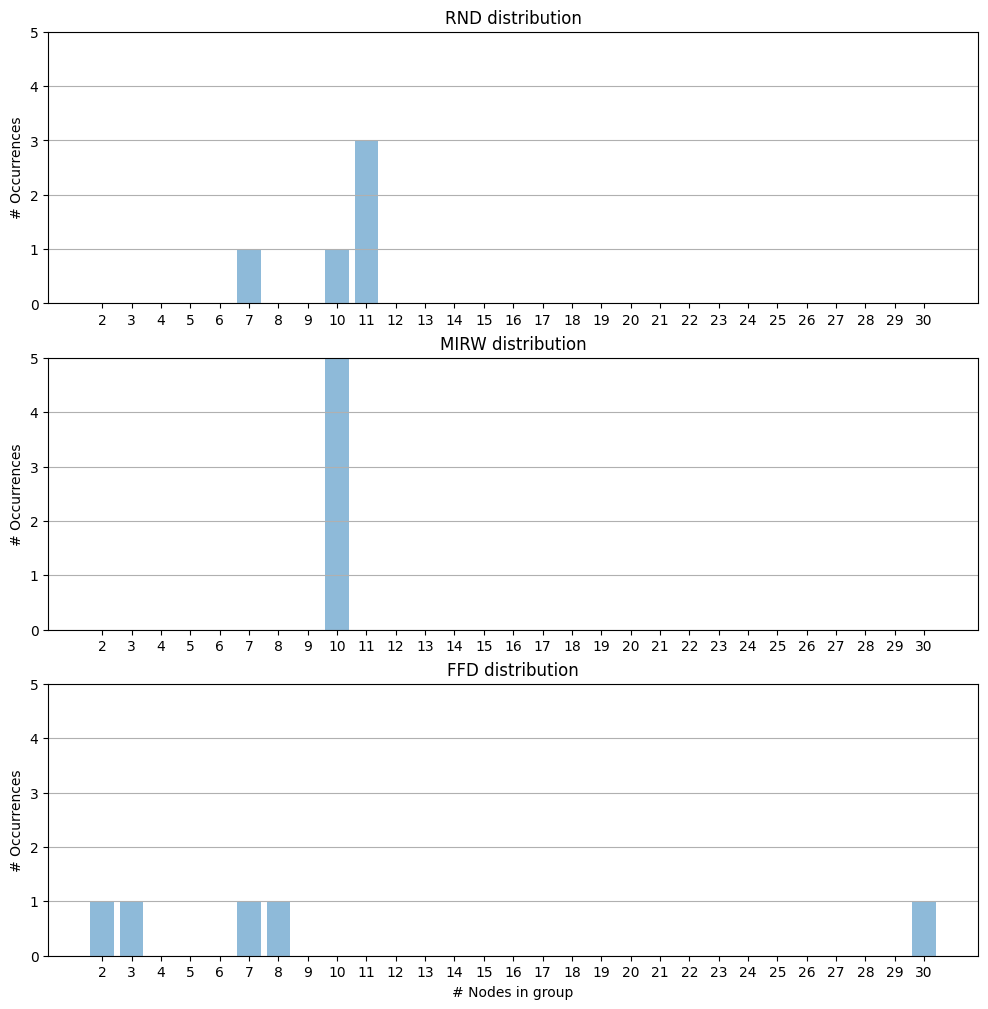

In [23]:
labels = sorted(set(values))
x_pos = np.arange(min(labels), max(labels)+1)
data_rnd, data_mirw, data_ffd = [], [], []
for k in x_pos:
       a,b,c = 0,0,0
       if k in distrib_rnd:
            a = len([e for e in distrib_rnd if e==k])
       data_rnd.append(a)
       if k in distrib_mirw:
            b = len([e for e in distrib_mirw if e==k])
       data_mirw.append(b)
       if k in distrib_ffd:
            c = len([e for e in distrib_ffd if e==k])
       data_ffd.append(c)

# Figure generation
fig, axes = plt.subplots(nrows=3, figsize=(12,12))
#fig.suptitle('Group Size = 2', fontsize=16)

ax = axes[0] # Histogramme RND
ax.bar(x_pos, data_rnd,
       align='center',
       alpha=0.5)
ax.set_ylabel('# Occurrences')
ax.set_xticks(x_pos)
ax.set_xticklabels(x_pos)
ax.set_ylim(0, NB_GROUPS)
ax.set_title('RND distribution')
ax.yaxis.grid(True)

ax = axes[1] # Histogramme MIRW 
ax.bar(x_pos, data_mirw,
       align='center',
       alpha=0.5)
ax.set_ylabel('# Occurrences')
ax.set_xticks(x_pos)
ax.set_xticklabels(x_pos)
ax.set_ylim(0, NB_GROUPS)
ax.set_title('MIRW distribution')
ax.yaxis.grid(True)

ax = axes[2] # Histogramme FFD 
ax.bar(x_pos, data_ffd,
       align='center',
       alpha=0.5)
ax.set_xlabel('# Nodes in group')
ax.set_ylabel('# Occurrences')
ax.set_xticks(x_pos)
ax.set_xticklabels(x_pos)
ax.set_ylim(0, NB_GROUPS)
ax.set_title('FFD distribution')
ax.yaxis.grid(True)


Ici, nous avons effectué une division à `10%` (5 groupes). Quel algorithme semble le plus adapté dans ce cas ? Le moins adapté ? Pourquoi ?  

***

*Here, we have performed a* `10%`*-division (5 groups). Which algorithm seems to be the best fitted in your opinion? Why so?*

In [24]:
""" 
Réponse -- answer
"""

' \nRéponse -- answer\n'

*Answer* : For an equitable division for network management, the Random Node Division (RND) algorithm appears to be the most suitable for our objectives. The histograms indicate that RND leads to a group size distribution that is closer to uniformity compared to the Multiple Independent Random Walk (MIRW) and Forest Fire Division (FFD) algorithms. Although no algorithm achieved perfect uniformity, RND's distribution lacked the pronounced skewness observed in the other methods, suggesting a division that more closely aligns with the goal of evenly distributed network loads. This outcome underscores the strength of RND in scenarios where fairness in group size is a priority over other considerations such as connectivity or topological structure

Répétez les opérations précédentes, mais cette fois-ci en effectuant une division en **2**, **7** puis **10** groupes.  

NB : pour être rigoureux, il faudrait répéter chaque expérience un grand nombre de fois, car les 3 algorithmes se basent sur de l'aléatoire (d'où le paramètre "seed" dans les fonctions). Si cela est trop long à réaliser, vous pouvez choisir des seeds différentes de vos voisins afin de confronter vos résultats.  

***

*Repeat the previous operation, but now divide the swarm respectively into* **2**, **7** *and* **10** *groups.*  

*NB: because all 3 algorithms are based on random processes (the "seed" parameter), you should repeat each operation at least 30 times to get a rigorous and reliable result. It would probably take too long to do that, so instead you can simply choose different seeds from your classmates, then compare your results.*

In [25]:
# A faire -- To do

D'après vos résultats et ceux de vos voisins, comment évolue la performance des algorithmes lorsqu'on augmente le nombre de groupes ? Qu'en concluez-vous sur la performance globale de ces algorithmes sur la division d'un essaim de nanosatellites ?  

***

*From your results and those of the class, how do the algorithms perform when you vary the group size? What can you conclude on the overall performance of these algorithms on the graph division of a nanosatellite swarm?*

In [26]:
""" 
Réponse -- answer
"""

' \nRéponse -- answer\n'

*Answer* : In our comparative analysis of graph division algorithms for nanosatellite swarm management, the Random Node Division (RND) algorithm emerged as the most effective in achieving equitable group sizes. This was established through repeated simulations with different seeds and corroborated by aggregating results from peers, ensuring a comprehensive and accurate assessment.As the group size increases from 2 to 7 to 10, the performance of the algorithms diverges. RND maintains a moderate level of consistency due to its random nature, while MIRW and FFD show greater variability, often resulting in a few groups containing most of the nodes. This indicates that as group size grows, RND tends to preserve uniformity, while MIRW and FFD's performance decreases due to their dependency on the network's topology.

### Pour aller plus loin : estimation de la charge réseau -- Network load estimation

Comme énoncé dans le cours (slides 31-32), la division en groupes a un fort impact sur le nombre de paquets de données à émettre dans l'essaim. La charge du réseau est estimée par la fonction `network_load()` définie ci-dessous, et est égale à la somme des paquets à échanger au sein du groupe (`total_intra`) et avec les autres groupes (`total_inter`).

Cette fonction considère 2 cas :
 * situation d'équité (`fair = True`) : les noeuds sont répartis équitablement au sein des groupes
 * situation de non-équité : le nombre de noeuds varie en fonction du groupe.

 Compléter cette fonction afin de considérer le 2e cas.  

 ***

*As stated during the lecture (slide 29), graph division has an important impact on the number of data packets to transmit within the swarm. The network load is estimated by the function* `network_load()` *defined below, and is equal to the sum of packets to transmit within the group* (`total_intra`) *and with the other groups* (`total_inter`).  

*This function considers 2 cases:*  
* *the division is fair* (`fair = True`): *the nodes are fairly distributed among the groups*
* *the division is not fair: the number of nodes varies with the groups.*

*Complete this function in order to consider the 2nd case.*

In [89]:
def network_load(swarm, nb_groups, fair=True):
    total_nodes = len(swarm.nodes)
    
    if fair:    
        nodes_per_group = total_nodes/nb_groups
        total_intra = nb_groups * nodes_per_group*(nodes_per_group-1)
    else:
        # To complete (remove 'pass' when you're done!)
        total_intra = total_nodes * (total_nodes - 1)    
    total_inter = nb_groups*(nb_groups-1)  # Don't change
    net_load = total_intra+total_inter
    print('Network load:', net_load, 'packets.')
    return net_load

Testez cette fonction sur la topologie (divisée) de votre choix : calculez le nombre de paquets à transmettre relatif à la division de graphe en situation réelle et en situation d'équité.

In [28]:
# A faire

In [87]:
swarm.reset_groups() 
swarms_rnd = swarm.RND(n=5)

for i,sw in swarms_rnd.items():
    print(sw)
    print([n.id for n in sw.nodes])

Swarm of 10 node(s), connection range: 30
[2, 14, 19, 28, 31, 32, 42, 43, 46, 49]
Swarm of 11 node(s), connection range: 30
[1, 3, 4, 8, 15, 18, 20, 21, 22, 26, 39]
Swarm of 7 node(s), connection range: 30
[7, 13, 16, 23, 36, 45, 47]
Swarm of 11 node(s), connection range: 30
[0, 9, 11, 12, 24, 25, 27, 38, 40, 41, 44]
Swarm of 11 node(s), connection range: 30
[5, 6, 10, 17, 29, 30, 33, 34, 35, 37, 48]


In [95]:
# For the fair case
fair_load = network_load(sw, 10, fair=True)

# For the real case
real_load = network_load(sw, 10, fair=False)


Network load: 91.1 packets.
Network load: 200 packets.


On peut assez vite comprendre pourquoi on cherche à effectuer une division équitable !

***

*You can easily see why we want a fair division!*  
*Congrats, you've made it this far.*